In [15]:
from typing import Tuple, List, Optional

import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from scipy.stats import invwishart

try:
    from umap import UMAP
except:
    from umap.umap_ import UMAP

# GM example:
* Sample and plot UMAP
* Build EM estimator of theta
* Compare to sklearn.GaussianMixture results

In [31]:
import itertools

class GM:
    """
        GMM sampler 
        - with K clusters
        - each cluster i with mean m[i] and std sigma[i] in \R^d, i = 1, ..., K
        - cluster probability phi[i], i = 1, ..., K
        - total parameters \theta = [(phi[i], mus[i], covs[i]) for i in range(K)]
        - phi = (phi[i] for i in range(K)) drawn from a symmetric Dirichlet(K, alpha) 
        - mus[i] is drawn from Guassian(d, mu, cov), 
        - covs[i] is drawn from InverseWishart(d, cov); inverse Wishart is conjugate to the distribution of covariance matrices; cov can be interpreted as a prior cov
        - priors:
            . alpha = [alpha[i] for i in range(K)]
            . mu
            . cov
        - hyperparameters:
            . d
            . K
            . seed
        - def sample(self, N):
            ...
    """
    def __init__(self,
                 d: int,
                 K: int,
                 *,
                 alpha: Optional[Tuple[int]] = None,
                 mu: Optional[np.ndarray[float]] = None,
                 cov: Optional[np.ndarray] = None,
                 seed: Optional[int] = None, 
                 verbose: bool = False,
                 debug: bool = False,
                 
    ):
        assert d > 0, f"Non-positive d: {d}"
        assert K > 0, f"Non-positive K: {K}"
        self.d = d
        self.K = K
        
        if alpha is None:
            alpha = np.ones(K)
        self.alpha = alpha
        
        if mu is None:
            mu = np.zeros(d)
        if cov is None:
            cov = np.eye(d)
        self.mu = mu
        self.cov = cov
        
        assert len(alpha) == K, "len(alpha) != K: {len(alpha)}"
        assert mu.shape == (d,), "mu.shape != (d,): {mu.shape}"
        assert cov.shape == (d,d), "cov.shape != (d,d): {cov.shape}"
        
        rng = self.rng = np.random.default_rng(seed)
        self.phi = rng.dirichlet(self.alpha).transpose()
        self.mus = rng.multivariate_normal(mu, cov, K)
            
        self.covs = invwishart.rvs(d, cov, random_state=rng, size=K)
        
        self.verbose, self.debug = verbose, debug
        if self.debug:
            print(f"DEBUG: GM: mus:\n{self.mus}")
            print(f"DEBUG: GM: covs:\n{self.covs}")
        
    def sample(self, N):
        rng = self.rng
        zcounts = rng.multinomial(N, self.phi, size=1)[0]
        if self.debug:
            print(f"DEBUG: GM.sample: N: {N}, zcounts: {zcounts}")
        zslist = []
        xs = np.zeros((N, self.d))
        zcc = 0
        for k in range(self.K):
            zc = zcounts[k]
            if self.debug:
                print(f"DEBUG: GM.sample: N: {N}, k: {k}, zc: {zc}")
            zslist += [k]*int(zc)
            xs[zcc:zcc+zc,:] = rng.multivariate_normal(self.mus[k], self.covs[k], zc)
            zcc += zc
        zs = np.array(zslist, dtype=int)
        return zs, xs

DEBUG: GM: mus:
[[  3.84809032  29.66239144]
 [ -1.6530765   19.46102492]
 [ -4.5795388    2.69188823]
 [ 11.00387733   8.77850094]
 [-13.06716128 -18.22576017]]
DEBUG: GM: covs:
[[[ 94.53473343 -26.02841734]
  [-26.02841734  41.08648576]]

 [[ 55.0610513   10.22956205]
  [ 10.22956205  17.20409816]]

 [[ 79.97467521   1.8894377 ]
  [  1.8894377   68.23104764]]

 [[385.77533137 -59.45165018]
  [-59.45165018 139.44244167]]

 [[592.33341984 -56.27426732]
  [-56.27426732 124.90154752]]]
DEBUG: GM.sample: N: 10000, zcounts: [ 328 4131 3863  403 1275]
DEBUG: GM.sample: N: 10000, k: 0, zc: 328
DEBUG: GM.sample: N: 10000, k: 1, zc: 4131
DEBUG: GM.sample: N: 10000, k: 2, zc: 3863
DEBUG: GM.sample: N: 10000, k: 3, zc: 403
DEBUG: GM.sample: N: 10000, k: 4, zc: 1275


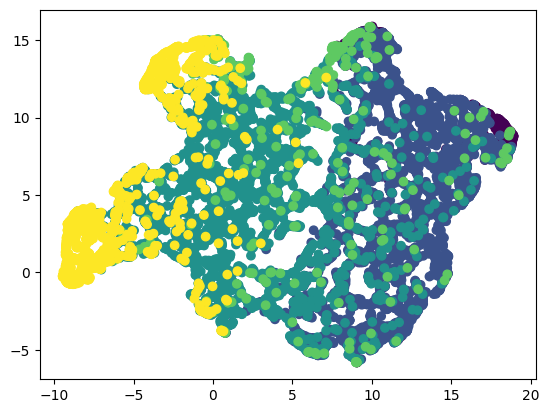

In [33]:
d = 2
K = 5
N = 10000
sigma = 100
Z, X = GM(d=d, K=K, cov=np.eye(d)*sigma, debug=True).sample(N)
UX = UMAP(random_state=42).fit_transform(X)
plt.scatter(UX[:, 0], UX[:, 1], c=Z)

In [18]:
class EM:
    ...